# 02_train
- Author: 
- Date: 2025-10-23
- Goal: 모델링/학습/통계/시각화
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [2]:
# This cell is only needed if xgboost is not installed in your environment.
# In Colab, run this once and then restart the runtime if necessary.
# option Cell !!! 
# xgboost 안깔려 있으면 주석 풀고 실행!
#!pip install -q xgboost

In [ ]:
# ================================
# Cell 1.5. Config loader utilities
# ================================
# 이 셀은 Config 파일을 로드하는 유틸리티 함수들을 정의합니다.
# Config 파일을 통해 경로, 모델 하이퍼파라미터, 실험 설정을 중앙에서 관리합니다.

import yaml  # YAML 파일 파싱 라이브러리

def load_config(config_path):
    """
    YAML config 파일을 로드하여 dict 반환
    
    역할:
    - configs/ 디렉토리의 YAML 파일을 읽어서 Python 딕셔너리로 변환
    - 노트북 실행 위치에 관계없이 올바른 경로를 찾아서 config 파일 로드
    
    사용 예시:
        config = load_config("configs/paths.yaml")
        # → {'paths': {'data': {...}, 'results': {...}}}
    
    Parameters
    ----------
    config_path : str
        Config 파일 경로 (상대 또는 절대 경로)
        예: "configs/paths.yaml", "configs/models.yaml"
    
    Returns
    -------
    dict
        로드된 config 딕셔너리 (YAML 구조 그대로)
    """
    # 현재 작업 디렉토리 확인
    notebook_dir = Path.cwd()
    
    # 노트북이 notebooks/ 디렉토리 안에서 실행되는지 확인
    # → 프로젝트 루트를 자동으로 찾기 위함
    if 'notebooks' in str(notebook_dir):
        project_root = notebook_dir.parent  # notebooks/의 부모 = 프로젝트 루트
    else:
        project_root = notebook_dir  # 이미 루트에서 실행 중
    
    # Config 파일 경로 처리
    config_file = Path(config_path)
    if not config_file.is_absolute():  # 상대 경로인 경우
        config_file = project_root / config_path  # 프로젝트 루트 기준으로 변환
    
    # YAML 파일 읽기 및 파싱
    with open(config_file, 'r', encoding='utf-8') as f:
        return yaml.safe_load(f)  # 안전하게 YAML을 딕셔너리로 변환


def get_paths(config_path="configs/paths.yaml"):
    """
    경로 config를 로드하고 절대 경로로 변환
    
    역할:
    - paths.yaml에서 경로 정보를 읽어서 절대 경로 객체(Path)로 변환
    - 모든 노트북에서 일관된 경로를 사용할 수 있도록 함
    
    사용 예시:
        paths = get_paths()
        npz_path = paths["data"]["processed"]
        # → Path('/Users/.../data/processed/colored_mnist/colored_mnist_100k_train_val.npz')
    
    Parameters
    ----------
    config_path : str
        경로 config 파일 경로 (기본값: "configs/paths.yaml")
    
    Returns
    -------
    dict
        절대 경로로 변환된 경로 딕셔너리
        구조: {
            "data": {
                "raw_mnist": Path(...),
                "processed": Path(...),
                ...
            },
            "results": {
                "metrics": Path(...),
                "figures": Path(...),
                ...
            }
        }
    """
    # Config 파일 로드
    config = load_config(config_path)
    paths = config['paths']  # 'paths' 키의 값 추출
    
    # 프로젝트 루트 찾기
    notebook_dir = Path.cwd()
    if 'notebooks' in str(notebook_dir):
        project_root = notebook_dir.parent
    else:
        project_root = notebook_dir
    
    # 상대 경로를 절대 경로(Path 객체)로 변환
    resolved = {}
    for key, value in paths.items():
        if isinstance(value, dict):  # 중첩된 딕셔너리인 경우 (예: data, results)
            # 각 하위 경로도 절대 경로로 변환
            resolved[key] = {k: project_root / v for k, v in value.items()}
        else:  # 단일 경로인 경우
            resolved[key] = project_root / value
    
    return resolved


def load_model_config(config_path="configs/models.yaml"):
    """
    모델 config를 로드
    
    역할:
    - models.yaml에서 모델별 하이퍼파라미터를 읽어옴
    - BASE_MODELS, PARAM_GRIDS, NEEDS_SCALING 등을 동적으로 생성하는데 사용
    
    사용 예시:
        model_config = load_model_config()
        knn_params = model_config["models"]["knn"]["base"]
        # → {'n_neighbors': 5, 'p': 2, 'metric': 'minkowski', ...}
    
    Parameters
    ----------
    config_path : str
        모델 config 파일 경로 (기본값: "configs/models.yaml")
    
    Returns
    -------
    dict
        모델 설정 딕셔너리
        구조: {
            "models": {
                "knn": {"base": {...}, "grid_search": {...}, "needs_scaling": true},
                "xgb": {...},
                ...
            },
            "use_gridsearch": {...}
        }
    """
    return load_config(config_path)


def load_experiment_config(config_path):
    """
    실험 config를 로드
    
    역할:
    - experiments/ 디렉토리의 실험별 설정 파일을 읽어옴
    - 어떤 모델을 사용할지, GridSearch를 사용할지 등의 실험 설정 관리
    
    사용 예시:
        exp_config = load_experiment_config("configs/experiments/digit_best.yaml")
        active_models = exp_config["active_models"]
        # → ['knn', 'svm', 'tree', 'rf', 'xgb']
    
    Parameters
    ----------
    config_path : str
        실험 config 파일 경로
        예: "configs/experiments/digit_best.yaml"
    
    Returns
    -------
    dict
        실험 설정 딕셔너리
        구조: {
            "experiment": {"name": "...", "task": "digit", ...},
            "active_models": [...],
            "use_gridsearch": {...},
            "evaluation": {...}
        }
    """
    return load_config(config_path)


print("[INFO] Config loader utilities defined.")



In [13]:
# ================================
# Cell 1. Imports & global config
# ================================
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost (install if necessary: !pip install xgboost)
from xgboost import XGBClassifier

# For notebook
%matplotlib inline

# Global random seed for reproducibility
RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Matplotlib configuration
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

print("[INFO] Libraries imported.")

[INFO] Libraries imported.


In [ ]:
# ===================================
# Cell 2. Paths & dataset information (Config-based)
# ===================================
# 이 셀은 데이터 경로와 결과 저장 경로를 설정합니다.
# 모든 경로는 configs/paths.yaml에서 중앙 관리되므로, 경로 변경 시 YAML만 수정하면 됩니다.

# ===== Config에서 경로 로드 =====
# get_paths() 함수를 사용하여 configs/paths.yaml의 모든 경로를 딕셔너리로 가져옵니다.
paths = get_paths("configs/paths.yaml")
# paths 구조:
# {
#   "data": {
#     "raw_mnist": Path(...),
#     "processed": Path(...)
#   },
#   "results": {
#     "metrics": Path(...),
#     "figures": Path(...),
#     "models": Path(...)
#   }
# }

# ===== 입력 데이터 경로 =====
# 01_preprocessing_colored_mnist.ipynb에서 생성한 전처리된 데이터셋 경로
# 이 파일에는 train/val split된 Colored MNIST 데이터가 저장되어 있습니다.
NPZ_PATH = paths["data"]["processed"]
# 예: data/processed/colored_mnist/colored_mnist_100k_train_val.npz
# 구조:
#   - X_train: (80000, 2352) - 학습용 이미지 (28*28*3 = 2352차원으로 평탄화)
#   - X_val: (20000, 2352) - 검증용 이미지
#   - y_digit_train/val: (80000,), (20000,) - 숫자 라벨 (0-9)
#   - y_fg_train/val: (80000,), (20000,) - 전경색 라벨 (0-6: ROYGBIV)
#   - y_bg_train/val: (80000,), (20000,) - 배경색 라벨 (0-6: ROYGBIV)

# ===== 프로젝트 루트 디렉토리 =====
# 현재 작업 디렉토리를 확인하고, 프로젝트 루트를 찾습니다.
BASE_DIR = Path.cwd()
if 'notebooks' in str(BASE_DIR):
    BASE_DIR = BASE_DIR.parent  # notebooks/의 부모 = 프로젝트 루트

# ===== 결과 저장 경로 =====
# 모델 학습 결과(메트릭, 시각화)를 저장할 디렉토리들
RESULTS_METRICS_DIR = paths["results"]["metrics"]  # CSV 형식의 평가 지표 저장 경로
RESULTS_FIGURES_DIR = paths["results"]["figures"]   # PNG 형식의 시각화 결과 저장 경로
# 예: results/metrics/, results/figures/

# 디렉토리가 없으면 자동으로 생성
os.makedirs(RESULTS_METRICS_DIR, exist_ok=True)
os.makedirs(RESULTS_FIGURES_DIR, exist_ok=True)

# ===== 이미지 크기 상수 =====
# Colored MNIST 이미지의 크기 (높이, 너비, 채널)
IMG_SHAPE = (28, 28, 3)  # 28x28 픽셀, RGB 3채널
# 평탄화하면 28*28*3 = 2352 차원의 벡터가 됩니다.

# ===== 정보 출력 =====
# 설정된 경로를 확인하기 위한 출력
print("[INFO] BASE_DIR      :", BASE_DIR)
print("[INFO] NPZ_PATH      :", NPZ_PATH)
print("[INFO] METRICS_DIR   :", RESULTS_METRICS_DIR)
print("[INFO] FIGURES_DIR   :", RESULTS_FIGURES_DIR)

print("[INFO] BASE_DIR      :", BASE_DIR)
print("[INFO] NPZ_PATH      :", NPZ_PATH)
print("[INFO] METRICS_DIR   :", RESULTS_METRICS_DIR)
print("[INFO] FIGURES_DIR   :", RESULTS_FIGURES_DIR)

[INFO] BASE_DIR      : /Users/jaehun_jung/colored-mnist-classification/notebooks
[INFO] NPZ_PATH      : /Users/jaehun_jung/colored-mnist-classification/notebooks/data/processed/colored_mnist/colored_mnist_100k_train_val.npz
[INFO] METRICS_DIR   : /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics
[INFO] FIGURES_DIR   : /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures


In [ ]:
# ==========================================
# Cell 3. Load processed Colored MNIST splits
# ==========================================
# 이 셀은 01_preprocessing_colored_mnist.ipynb에서 생성한 전처리된 데이터를 로드합니다.
# 데이터는 train/val로 이미 분할되어 있으며, 3가지 task(digit, fg, bg)의 라벨이 모두 포함되어 있습니다.

# ===== 데이터 파일 존재 확인 =====
# NPZ 파일이 존재하는지 확인하고, 없으면 에러를 발생시킵니다.
# 이 파일은 01 노트북을 먼저 실행해야 생성됩니다.
if not os.path.exists(NPZ_PATH):
    raise FileNotFoundError(f"[ERROR] Processed dataset not found at: {NPZ_PATH}")

# ===== NPZ 파일 로드 =====
# NumPy의 npz 형식으로 저장된 데이터를 로드합니다.
# npz는 여러 배열을 하나의 파일에 저장하는 압축 형식입니다.
data = np.load(NPZ_PATH)

# ===== 이미지 데이터 로드 =====
# 평탄화된 컬러 이미지: (N, 2352) 형태
# - 28*28*3 = 2352 차원 (원본 28x28 RGB 이미지를 1차원 벡터로 변환)
# - float32 타입, 픽셀 값 범위: [0, 255]
X_train = data["X_train"]  # 학습용 이미지: (80000, 2352)
X_val   = data["X_val"]    # 검증용 이미지: (20000, 2352)

# ===== Task 1: Digit Classification 라벨 =====
# 숫자 분류 task의 라벨 (0-9, 총 10개 클래스)
y_digit_train = data["y_digit_train"]  # 학습용 숫자 라벨: (80000,)
y_digit_val   = data["y_digit_val"]    # 검증용 숫자 라벨: (20000,)

# ===== Task 2: Foreground Color Classification 라벨 =====
# 전경색(숫자 색상) 분류 task의 라벨 (0-6: ROYGBIV, 총 7개 클래스)
# 0=Red, 1=Orange, 2=Yellow, 3=Green, 4=Blue, 5=Indigo, 6=Violet
y_fg_train = data["y_fg_train"]  # 학습용 전경색 라벨: (80000,)
y_fg_val   = data["y_fg_val"]    # 검증용 전경색 라벨: (20000,)

# ===== Task 3: Background Color Classification 라벨 =====
# 배경색 분류 task의 라벨 (0-6: ROYGBIV, 총 7개 클래스)
y_bg_train = data["y_bg_train"]  # 학습용 배경색 라벨: (80000,)
y_bg_val   = data["y_bg_val"]    # 검증용 배경색 라벨: (20000,)

# ===== 데이터 출처 정보 (선택적) =====
# 각 샘플이 어떤 증강 방법으로 생성되었는지 기록
# "raw": 원본 MNIST
# "deskew": Deskew 증강
# "font": Font 증강
# "geom": Geometric 증강
source_train = data["source_train"]  # 학습 데이터 출처: (80000,)
source_val   = data["source_val"]    # 검증 데이터 출처: (20000,)

# ===== 데이터 로드 정보 출력 =====
print("[INFO] Dataset loaded from npz.")
print("  X_train shape:", X_train.shape, "dtype:", X_train.dtype)
print("  X_val   shape:", X_val.shape,   "dtype:", X_val.dtype)
print("  y_digit_train shape:", y_digit_train.shape)
print("  y_fg_train    shape:", y_fg_train.shape)
print("  y_bg_train    shape:", y_bg_train.shape)

# ===== 데이터 일관성 검증 =====
# 데이터가 올바르게 로드되었는지 확인하는 검증 단계
# 1. 이미지 차원이 28*28*3 = 2352인지 확인
assert X_train.shape[1] == 28 * 28 * 3, "[ERROR] Feature dimension must be 28*28*3."
# 2. 학습 데이터의 샘플 수가 모든 라벨과 일치하는지 확인
assert len(X_train) == len(y_digit_train) == len(y_fg_train) == len(y_bg_train)
# 3. 검증 데이터의 샘플 수가 모든 라벨과 일치하는지 확인
assert len(X_val)   == len(y_digit_val)   == len(y_fg_val)   == len(y_bg_val)

print("[INFO] Basic consistency checks passed.")


[INFO] Dataset loaded from npz.
  X_train shape: (80000, 2352) dtype: float32
  X_val   shape: (20000, 2352) dtype: float32
  y_digit_train shape: (80000,)
  y_fg_train    shape: (80000,)
  y_bg_train    shape: (80000,)
[INFO] Basic consistency checks passed.


In [16]:
# =====================================================
# Cell 4. Task selection helper (digit / fg / bg labels)
# =====================================================
# Map each task name to its corresponding labels and description
TASK_LABEL_INFO = {
    "digit": {
        "y_train": y_digit_train,
        "y_val":   y_digit_val,
        "task_desc": "Digit classification (0-9)",
    },
    "fg": {
        "y_train": y_fg_train,
        "y_val":   y_fg_val,
        "task_desc": "Foreground color classification (7 classes, ROYG BIV)",
    },
    "bg": {
        "y_train": y_bg_train,
        "y_val":   y_bg_val,
        "task_desc": "Background color classification (7 classes, ROYG BIV)",
    },
}

# Which tasks to run (you can restrict this list when debugging)
ACTIVE_TASKS = ["digit", "fg", "bg"]  # e.g., ["digit"] for digit-only experiments
print("[INFO] Active tasks:", ACTIVE_TASKS)


[INFO] Active tasks: ['digit', 'fg', 'bg']


In [17]:
# ==========================================
# Cell 5. Visualization helpers (EDA)
# ==========================================
def reconstruct_images(X_flat, n_samples=16):
    """
    Reconstruct RGB images from flattened feature vectors for visualization.
    """
    n = min(n_samples, X_flat.shape[0])
    idxs = np.random.choice(X_flat.shape[0], size=n, replace=False)
    imgs = X_flat[idxs].reshape(n, *IMG_SHAPE)
    return imgs, idxs


def plot_sample_images(X_flat, y, title, n_samples=16):
    """
    Plot a grid of sample images with their labels.
    """
    imgs, idxs = reconstruct_images(X_flat, n_samples=n_samples)
    n = imgs.shape[0]
    cols = min(8, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 1.5, rows * 1.5))
    for i, (img, idx) in enumerate(zip(imgs, idxs)):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img / 255.0)  # scale to [0,1] for visualization
        ax.axis("off")
        ax.set_title(str(int(y[idx])), fontsize=8)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_label_distribution_2way(y_train, y_val, task_name):
    """
    Plot label distribution for train/val splits for a given task.
    """
    def counts(y):
        return pd.Series(y).value_counts().sort_index()

    train_c = counts(y_train)
    val_c   = counts(y_val)

    df = pd.DataFrame({
        "label": train_c.index,
        "train": train_c.values,
        "val":   val_c.values,
    })

    print(f"\n[EDA] Label distribution for task = {task_name}")
    print(df)

    x = np.arange(len(df["label"]))
    width = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - width / 2, df["train"], width=width, label="train")
    plt.bar(x + width / 2, df["val"],   width=width, label="val")

    plt.xticks(x, df["label"])
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title(f"Label distribution per split ({task_name})")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_source_distribution(source_train, source_val):
    """
    Plot distribution of data sources (raw / deskew / font / geom) in train/val.
    """
    train_counts = pd.Series(source_train).value_counts().sort_index()
    val_counts   = pd.Series(source_val).value_counts().sort_index()

    df = pd.DataFrame({
        "source": train_counts.index,
        "train": train_counts.values,
        "val":   val_counts.reindex(train_counts.index).values,
    })

    print("\n[EDA] Source distribution (train/val):")
    print(df)

    x = np.arange(len(df["source"]))
    width = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - width / 2, df["train"], width=width, label="train")
    plt.bar(x + width / 2, df["val"],   width=width, label="val")
    plt.xticks(x, df["source"])
    plt.xlabel("Source")
    plt.ylabel("Count")
    plt.title("Source distribution per split (raw / deskew / font / geom)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [18]:
# ==========================================
# Cell 6. Evaluation & plotting utilities
# ==========================================
def compute_metrics(y_true, y_pred, average="macro"):
    """
    Compute accuracy, precision, recall, and F1-score (macro-averaged by default).
    """
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    return acc, prec, rec, f1


def plot_confusion_matrix(y_true, y_pred, classes, title, save_path=None):
    """
    Plot confusion matrix as a heatmap.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=classes,
        yticklabels=classes,
        cmap="YlGnBu",
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("[INFO] Saved confusion matrix to:", save_path)

    plt.show()


def show_prediction_examples(model_name, pipeline, X, y_true, task_name, n=12):
    """
    Show images with true vs predicted labels for qualitative verification.
    Uses validation set here (since no test set exists).
    """
    n = min(n, X.shape[0])
    idxs = np.random.choice(X.shape[0], size=n, replace=False)
    X_sample = X[idxs]
    y_sample_true = y_true[idxs]
    y_sample_pred = pipeline.predict(X_sample)

    imgs = X_sample.reshape(n, *IMG_SHAPE)

    cols = min(6, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 2, rows * 2.2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(imgs[i] / 255.0)
        ax.axis("off")
        ax.set_title(
            f"T:{int(y_sample_true[i])} / P:{int(y_sample_pred[i])}",
            fontsize=8,
        )
    plt.suptitle(f"{task_name} - {model_name}: prediction examples (val set)", fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_feature_importance_heatmap(feature_importances, title, save_path=None):
    """
    Visualize feature importances (flattened 2352-dim vector) as a heatmap over 28x28 pixels,
    by averaging the 3 RGB channels.
    """
    if feature_importances.shape[0] != 28 * 28 * 3:
        print("[WARN] Unexpected feature_importances length:", feature_importances.shape[0])
        return

    # Reshape to (28, 28, 3) and average across RGB channels
    imp_3d = feature_importances.reshape(28, 28, 3)
    imp_2d = imp_3d.mean(axis=2)

    plt.figure(figsize=(4, 4))
    sns.heatmap(imp_2d, cmap="viridis")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("[INFO] Saved feature importance heatmap to:", save_path)

    plt.show()

In [ ]:
# ==========================================
# Cell 7. Model definitions & GridSearch configs (Config-based)
# ==========================================
# 이 셀은 configs/models.yaml에서 모델 설정을 로드하여 모델 인스턴스를 동적으로 생성합니다.
# 하이퍼파라미터를 코드에 하드코딩하지 않고, YAML 파일에서 관리할 수 있습니다.

# ===== Config 파일에서 모델 설정 로드 =====
# models.yaml 파일을 읽어서 모든 모델의 하이퍼파라미터를 가져옵니다.
model_config = load_model_config("configs/models.yaml")
models_cfg = model_config["models"]  # 모델별 설정 딕셔너리
use_gridsearch_cfg = model_config["use_gridsearch"]  # GridSearch 사용 여부 설정

# ===== BASE_MODELS 딕셔너리 생성 =====
# 각 모델의 기본 하이퍼파라미터를 사용하여 모델 인스턴스를 생성합니다.
# 이 딕셔너리는 train_single_model() 함수에서 사용됩니다.
BASE_MODELS = {}
for model_name, model_params in models_cfg.items():
    # 기본 하이퍼파라미터 복사 (원본 수정 방지)
    base_params = model_params["base"].copy()
    
    # 재현성을 위해 random_state가 필요한 모델에 시드 추가
    # Tree 계열 모델과 Logistic Regression은 랜덤 시드가 필요합니다.
    if model_name in ["logreg", "tree", "rf", "xgb"]:
        base_params["random_state"] = RANDOM_SEED
    
    # 모델 타입에 따라 적절한 클래스로 인스턴스 생성
    if model_name == "logreg":
        BASE_MODELS[model_name] = LogisticRegression(**base_params)
    elif model_name == "knn":
        BASE_MODELS[model_name] = KNeighborsClassifier(**base_params)
    elif model_name == "svm":
        BASE_MODELS[model_name] = SVC(**base_params)
    elif model_name == "tree":
        BASE_MODELS[model_name] = DecisionTreeClassifier(**base_params)
    elif model_name == "rf":
        BASE_MODELS[model_name] = RandomForestClassifier(**base_params)
    elif model_name == "xgb":
        BASE_MODELS[model_name] = XGBClassifier(**base_params)

# ===== NEEDS_SCALING 딕셔너리 생성 =====
# 각 모델이 StandardScaler를 필요로 하는지 여부를 저장합니다.
# - True: StandardScaler 필요 (KNN, SVM, Logistic Regression)
# - False: StandardScaler 불필요 (Tree 계열 모델들)
# build_pipeline() 함수에서 이 정보를 사용하여 Pipeline을 구성합니다.
NEEDS_SCALING = {
    model_name: model_params["needs_scaling"]
    for model_name, model_params in models_cfg.items()
}

# ===== PARAM_GRIDS 딕셔너리 생성 =====
# GridSearchCV에 사용할 하이퍼파라미터 그리드를 생성합니다.
# 각 모델의 "grid_search" 섹션에 정의된 파라미터 범위를 사용합니다.
PARAM_GRIDS = {}
for model_name, model_params in models_cfg.items():
    if "grid_search" in model_params:  # GridSearch 설정이 있는 경우만
        PARAM_GRIDS[model_name] = model_params["grid_search"]
# 예: PARAM_GRIDS["knn"] = {"clf__n_neighbors": [3, 5, 7, 11], ...}

# ===== USE_GRIDSEARCH 딕셔너리 생성 =====
# 각 모델에 대해 GridSearchCV를 사용할지 여부를 설정합니다.
# False로 설정하면 기본 하이퍼파라미터만 사용합니다.
USE_GRIDSEARCH = use_gridsearch_cfg.copy()

# ===== 실행할 모델 선택 =====
# 실제로 학습할 모델 목록을 지정합니다.
# 모든 모델을 실행하려면: ACTIVE_MODELS = ["logreg", "knn", "svm", "tree", "rf", "xgb"]
# 특정 모델만 테스트하려면: ACTIVE_MODELS = ["knn"]
ACTIVE_MODELS = ["knn"]  # 필요에 따라 수정 가능
print("[INFO] Active models:", ACTIVE_MODELS)
print("[INFO] Models loaded from config:", list(BASE_MODELS.keys()))


def build_pipeline(model_name, base_estimator):
    """
    Build sklearn Pipeline for a given model:
      - If NEEDS_SCALING[model_name] is True:
          [StandardScaler] -> [Classifier]
      - Otherwise:
          [Classifier] only
    """
    if NEEDS_SCALING[model_name]:
        steps = [("scaler", StandardScaler()), ("clf", base_estimator)]
    else:
        steps = [("clf", base_estimator)]
    pipe = Pipeline(steps)
    return pipe


def train_single_model(
    model_name,
    X_train,
    y_train,
    X_val,
    y_val,
    task_name,
    use_gridsearch=True,
):
    """
    Train a single model (optionally with GridSearchCV) and evaluate on val set.

    Returns
    -------
    best_pipeline : trained Pipeline
    metrics_val   : dict with accuracy, precision, recall, f1 (macro)
    """
    print("\n==============================")
    print(f"[TASK: {task_name}] Training model: {model_name}")
    print("==============================")

    base_estimator = BASE_MODELS[model_name]
    pipe = build_pipeline(model_name, base_estimator)

    if use_gridsearch and model_name in PARAM_GRIDS:
        param_grid = PARAM_GRIDS[model_name]
        print("[INFO] Running GridSearchCV for", model_name)
        grid = GridSearchCV(
            pipe,
            param_grid=param_grid,
            cv=3,
            n_jobs=-1,
            scoring="accuracy",
            verbose=1,
        )
        grid.fit(X_train, y_train)
        best_pipeline = grid.best_estimator_
        print("[INFO] Best params:", grid.best_params_)
        print("[INFO] Best CV accuracy:", grid.best_score_)
    else:
        print("[INFO] Training without GridSearch (fixed hyperparameters).")
        pipe.fit(X_train, y_train)
        best_pipeline = pipe

    # Validation performance
    y_val_pred = best_pipeline.predict(X_val)
    acc, prec, rec, f1 = compute_metrics(y_val, y_val_pred, average="macro")

    print("\n[VAL] metrics (macro) for", model_name)
    print(f"  accuracy : {acc:.4f}")
    print(f"  precision: {prec:.4f}")
    print(f"  recall   : {rec:.4f}")
    print(f"  f1-score : {f1:.4f}")

    print("\n[VAL] classification_report:")
    print(classification_report(y_val, y_val_pred, digits=4))

    metrics_val = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    return best_pipeline, metrics_val



[INFO] Active models: ['knn']



[EDA] Source distribution (train/val):
   source  train    val
0  deskew  16027   3973
1    font   7957   2043
2    geom   7962   2038
3     raw  48054  11946


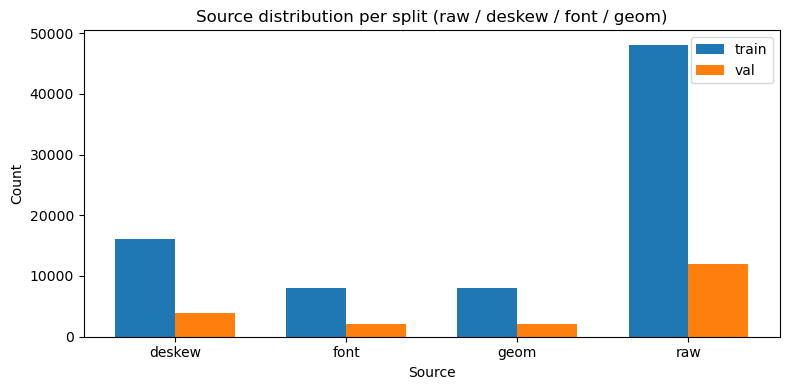



##########################################
### Task: digit - Digit classification (0-9)
##########################################

[EDA] Label distribution for task = digit
   label  train   val
0      0   7873  1968
1      1   8874  2218
2      2   7982  1996
3      3   8183  2046
4      4   7873  1968
5      5   7275  1819
6      6   7923  1980
7      7   8291  2073
8      8   7843  1961
9      9   7883  1971


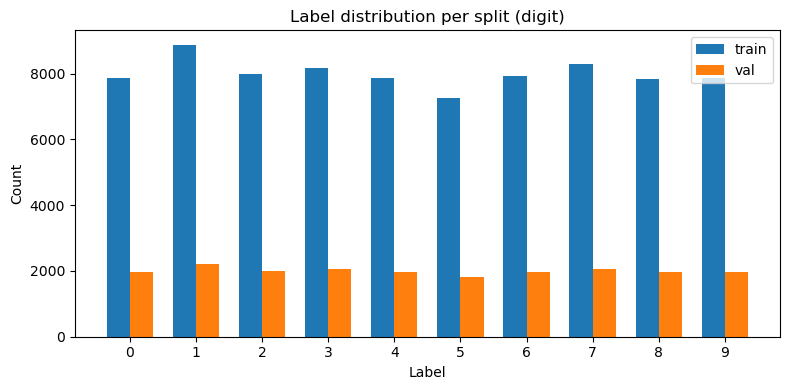

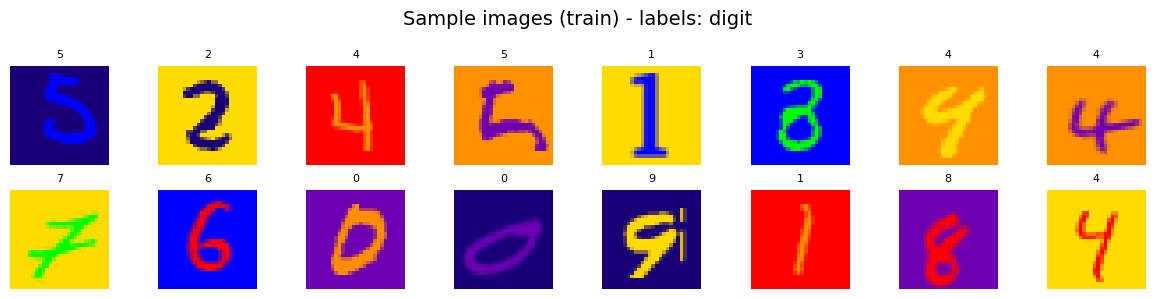


[TASK: digit] Training model: knn
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for knn
  accuracy : 0.9020
  precision: 0.9061
  recall   : 0.9006
  f1-score : 0.9018

[VAL] classification_report:
              precision    recall  f1-score   support

           0     0.9386    0.9553    0.9469      1968
           1     0.8275    0.9883    0.9008      2218
           2     0.9679    0.8617    0.9117      1996
           3     0.9098    0.8876    0.8986      2046
           4     0.9245    0.8582    0.8901      1968
           5     0.9120    0.8719    0.8915      1819
           6     0.9258    0.9576    0.9414      1980
           7     0.8909    0.9175    0.9040      2073
           8     0.9354    0.8338    0.8816      1961
           9     0.8292    0.8742    0.8511      1971

    accuracy                         0.9020     20000
   macro avg     0.9061    0.9006    0.9018     20000
weighted avg     0.9051    0.9020    0.9019     20000


[VAL

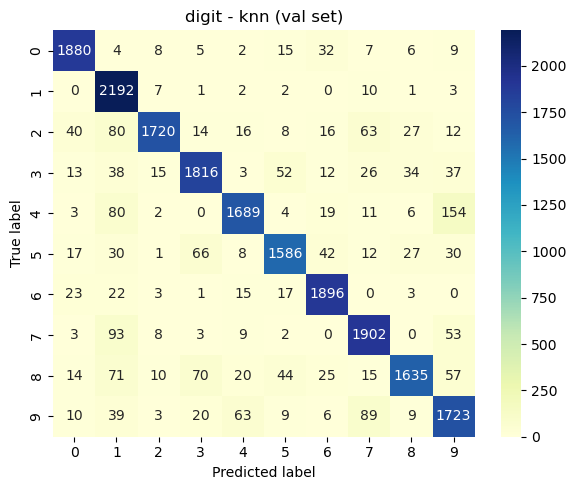

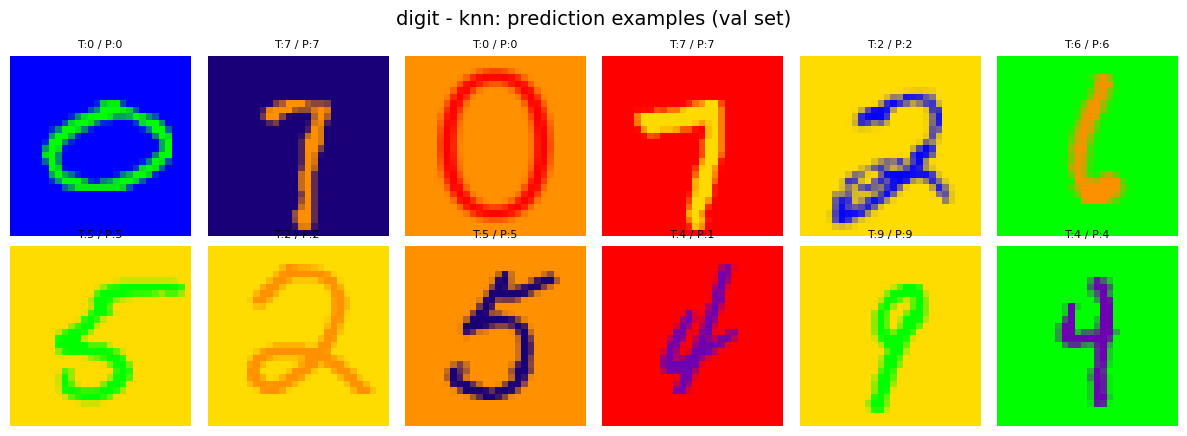



##########################################
### Task: fg - Foreground color classification (7 classes, ROYG BIV)
##########################################

[EDA] Label distribution for task = fg
   label  train   val
0      0  11428  2915
1      1  11391  2860
2      2  11323  2908
3      3  11589  2855
4      4  11385  2809
5      5  11547  2847
6      6  11337  2806


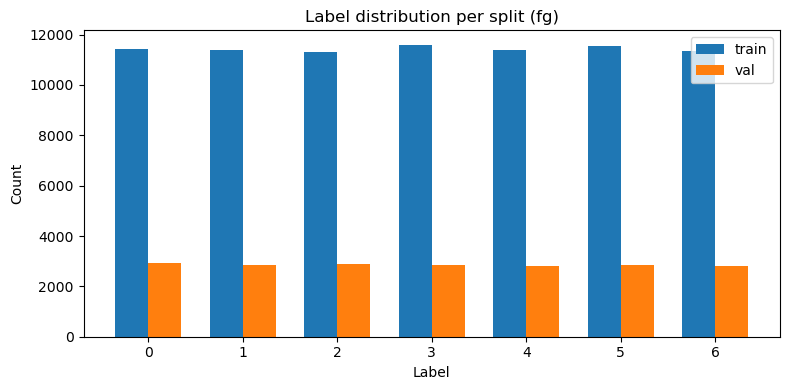

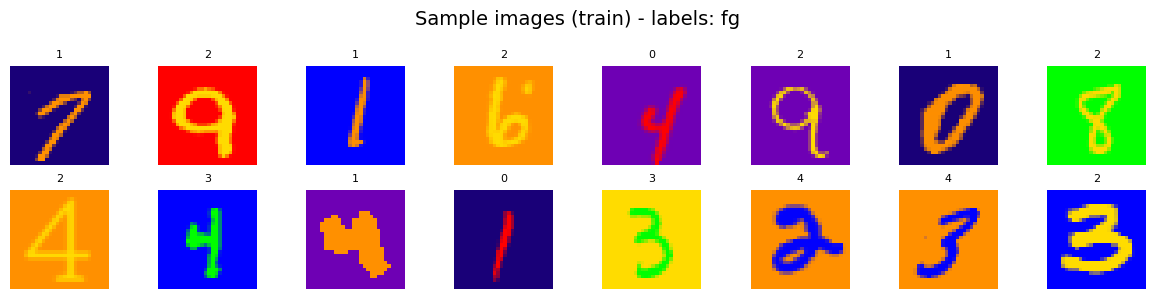


[TASK: fg] Training model: knn
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for knn
  accuracy : 0.8514
  precision: 0.8757
  recall   : 0.8516
  f1-score : 0.8513

[VAL] classification_report:
              precision    recall  f1-score   support

           0     0.9840    0.8844    0.9315      2915
           1     0.6687    0.9031    0.7684      2860
           2     0.9084    0.6479    0.7563      2908
           3     1.0000    0.9751    0.9874      2855
           4     0.9963    0.6757    0.8053      2809
           5     0.8369    0.9642    0.8960      2847
           6     0.7358    0.9109    0.8140      2806

    accuracy                         0.8514     20000
   macro avg     0.8757    0.8516    0.8513     20000
weighted avg     0.8762    0.8514    0.8514     20000


[VAL FINAL] fg - knn
  accuracy : 0.8514
  precision: 0.8757
  recall   : 0.8516
  f1-score : 0.8513
[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-c

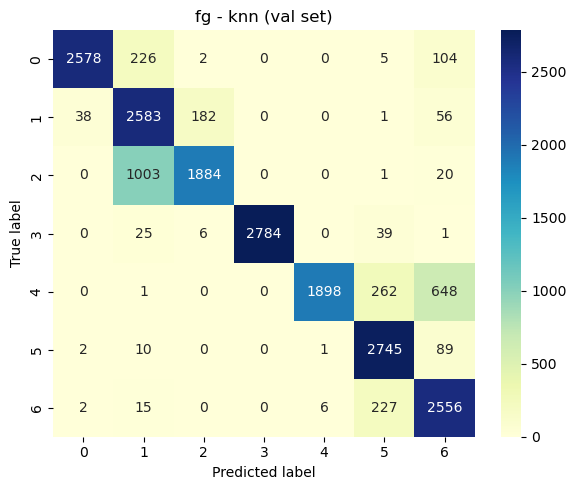

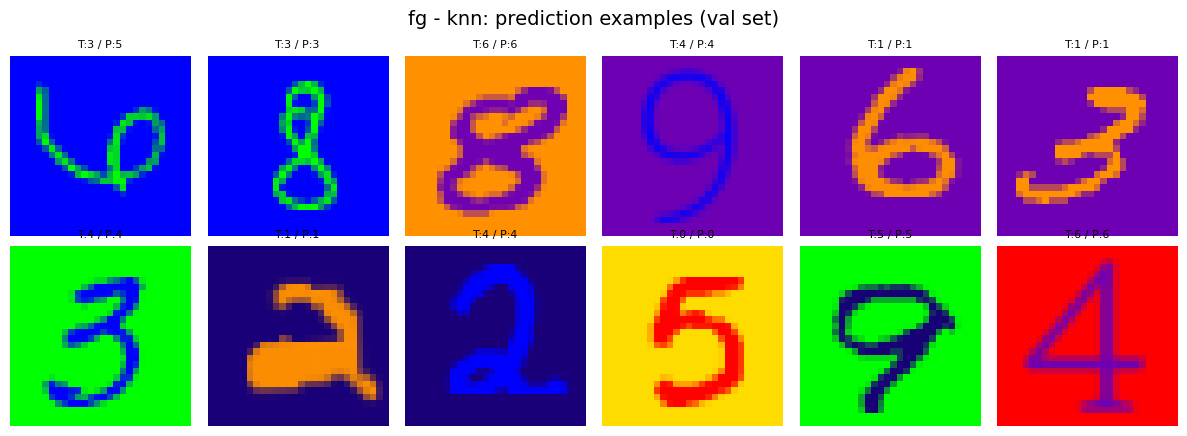



##########################################
### Task: bg - Background color classification (7 classes, ROYG BIV)
##########################################

[EDA] Label distribution for task = bg
   label  train   val
0      0  11411  2877
1      1  11299  2818
2      2  11570  2816
3      3  11472  2856
4      4  11619  3001
5      5  11408  2849
6      6  11221  2783


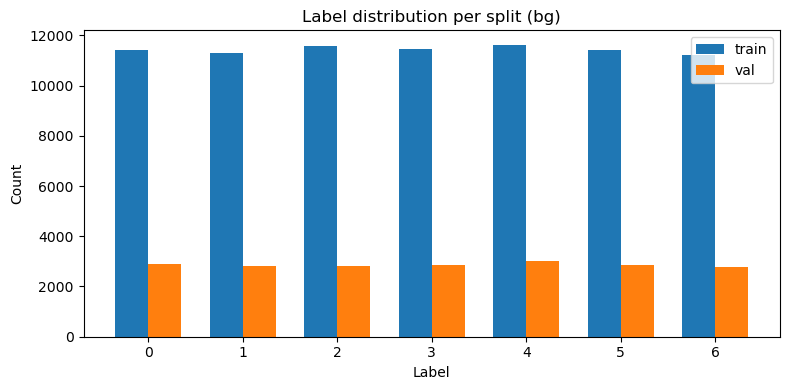

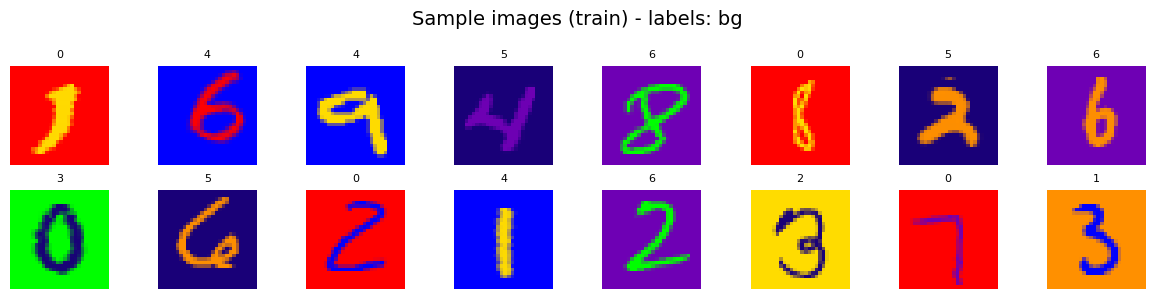


[TASK: bg] Training model: knn
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for knn
  accuracy : 0.9999
  precision: 0.9998
  recall   : 0.9998
  f1-score : 0.9998

[VAL] classification_report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2877
           1     0.9989    1.0000    0.9995      2818
           2     1.0000    0.9989    0.9995      2816
           3     1.0000    1.0000    1.0000      2856
           4     1.0000    1.0000    1.0000      3001
           5     1.0000    1.0000    1.0000      2849
           6     1.0000    1.0000    1.0000      2783

    accuracy                         0.9999     20000
   macro avg     0.9998    0.9998    0.9998     20000
weighted avg     0.9999    0.9999    0.9998     20000


[VAL FINAL] bg - knn
  accuracy : 0.9999
  precision: 0.9998
  recall   : 0.9998
  f1-score : 0.9998
[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-c

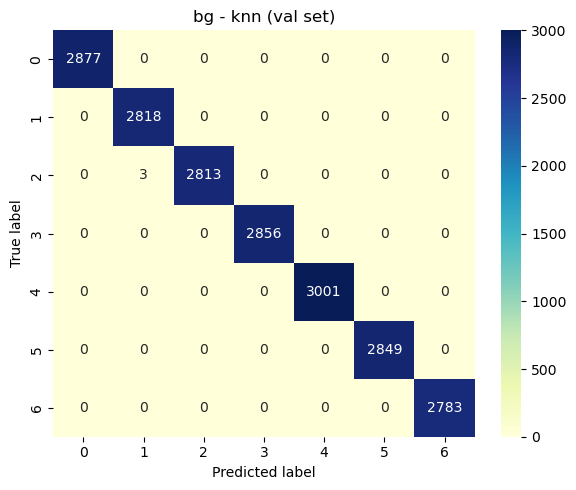

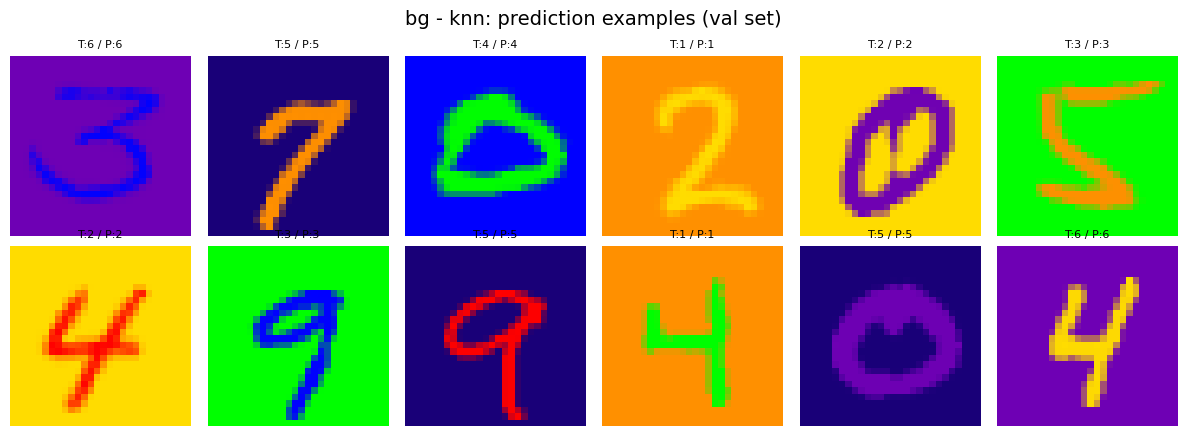

In [20]:
# ==========================================
# Cell 8. Main training loop over tasks/models
# ==========================================
all_results = []  # will store metrics for all (task, model, split)

# EDA: source distribution (once)
plot_source_distribution(source_train, source_val)

for task_name in ACTIVE_TASKS:
    info = TASK_LABEL_INFO[task_name]
    y_train_task = info["y_train"]
    y_val_task   = info["y_val"]
    task_desc    = info["task_desc"]

    print("\n\n##########################################")
    print(f"### Task: {task_name} - {task_desc}")
    print("##########################################")

    # EDA: label distribution
    plot_label_distribution_2way(y_train_task, y_val_task, task_name)

    # EDA: sample images (using training split, labels from this task)
    plot_sample_images(
        X_flat=X_train,
        y=y_train_task,
        title=f"Sample images (train) - labels: {task_name}",
        n_samples=16,
    )

    # Classes sorted for confusion matrix axis
    classes = np.sort(np.unique(y_train_task))

    # Dictionary to store trained pipelines for this task
    trained_pipelines = {}

    # Loop over models selected in ACTIVE_MODELS
    for model_name in ACTIVE_MODELS:
        # Train (with or without GridSearch depending on USE_GRIDSEARCH flag)
        use_grid = USE_GRIDSEARCH.get(model_name, False)
        best_pipe, val_metrics = train_single_model(
            model_name=model_name,
            X_train=X_train,
            y_train=y_train_task,
            X_val=X_val,
            y_val=y_val_task,
            task_name=task_name,
            use_gridsearch=use_grid,
        )

        trained_pipelines[model_name] = best_pipe

        # Evaluate on validation set (no separate test set yet)
        y_val_pred = best_pipe.predict(X_val)
        acc_val, prec_val, rec_val, f1_val = compute_metrics(
            y_val_task, y_val_pred, average="macro"
        )

        print(f"\n[VAL FINAL] {task_name} - {model_name}")
        print(f"  accuracy : {acc_val:.4f}")
        print(f"  precision: {prec_val:.4f}")
        print(f"  recall   : {rec_val:.4f}")
        print(f"  f1-score : {f1_val:.4f}")

        # Confusion matrix on validation set
        cm_title = f"{task_name} - {model_name} (val set)"
        cm_filename = f"cm_{task_name}_{model_name}_val.png"
        cm_path = os.path.join(RESULTS_FIGURES_DIR, cm_filename)
        plot_confusion_matrix(
            y_true=y_val_task,
            y_pred=y_val_pred,
            classes=classes,
            title=cm_title,
            save_path=cm_path,
        )

        # Feature importance for tree-based models (DecisionTree, RandomForest, XGBoost)
        if model_name in ["tree", "rf", "xgb"]:
            clf = best_pipe.named_steps["clf"]
            if hasattr(clf, "feature_importances_"):
                fi = clf.feature_importances_
                fi_title = f"{task_name} - {model_name} feature importance (avg over RGB)"
                fi_filename = f"feat_importance_{task_name}_{model_name}.png"
                fi_path = os.path.join(RESULTS_FIGURES_DIR, fi_filename)
                plot_feature_importance_heatmap(
                    feature_importances=fi,
                    title=fi_title,
                    save_path=fi_path,
                )
            else:
                print(f"[WARN] Model {model_name} does not expose feature_importances_.")

        # Qualitative prediction examples (true vs predicted labels) on val set
        show_prediction_examples(
            model_name=model_name,
            pipeline=best_pipe,
            X=X_val,
            y_true=y_val_task,
            task_name=task_name,
            n=12,
        )

        # Store validation metrics
        all_results.append({
            "task": task_name,
            "task_desc": task_desc,
            "model": model_name,
            "split": "val",
            "accuracy": acc_val,
            "precision": prec_val,
            "recall": rec_val,
            "f1": f1_val,
        })


In [21]:
# ==========================================
# Cell 9. Metrics table (for report) + save CSV
# ==========================================
results_df = pd.DataFrame(all_results)

# Sort by task, split, and accuracy (descending on accuracy)
results_df_sorted = results_df.sort_values(
    by=["task", "split", "accuracy"],
    ascending=[True, True, False],
).reset_index(drop=True)

print("\n\n===== Summary metrics table (all tasks / models) =====")
print(results_df_sorted)

# Save overall CSV
overall_csv_path = os.path.join(
    RESULTS_METRICS_DIR,
    "classical_ml_all_tasks_metrics.csv",
)
results_df_sorted.to_csv(overall_csv_path, index=False)
print("\n[INFO] Saved overall metrics CSV to:", overall_csv_path)

# Save per-task CSV for easier report usage / 03 notebook
for task_name in ACTIVE_TASKS:
    task_df = results_df_sorted[results_df_sorted["task"] == task_name]
    task_csv_path = os.path.join(
        RESULTS_METRICS_DIR,
        f"{task_name}_classical_ml_metrics.csv",
    )
    task_df.to_csv(task_csv_path, index=False)
    print(f"[INFO] Saved metrics CSV for task={task_name} to:", task_csv_path)

print("\n[INFO] Classical ML training & evaluation pipeline finished.")



===== Summary metrics table (all tasks / models) =====
    task                                          task_desc model split  \
0     bg  Background color classification (7 classes, RO...   knn   val   
1  digit                         Digit classification (0-9)   knn   val   
2     fg  Foreground color classification (7 classes, RO...   knn   val   

   accuracy  precision    recall        f1  
0   0.99985   0.999848  0.999848  0.999848  
1   0.90195   0.906147  0.900603  0.901768  
2   0.85140   0.875711  0.851614  0.851282  

[INFO] Saved overall metrics CSV to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics/classical_ml_all_tasks_metrics.csv
[INFO] Saved metrics CSV for task=digit to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics/digit_classical_ml_metrics.csv
[INFO] Saved metrics CSV for task=fg to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics/fg_classical_ml_metrics.csv
[INFO] Saved metrics CS